# Introduction
(10 marks)

## Background
1 paragraph of at least 6 lines

## Research Problem
1 paragraph of at least 6 lines

## Objectives
- Develop a text classification model to accurately categorize job descriptions into one of 16 predefined categories (targets) based on their text content. The categories are: 
1. Admin, HR, CS, Office Support
2. Marketing, Sales
3. Media, Communcation
4. Finance, Accounting
5. Information Technology
6. Education, Training
7. Social Services
8. Healthcare, Medical
9. Science, Research
10. Construction, Artisans, Skilled Trade
11. Legal, Security, Law Enforcement
12. Hospitality, Tourism
13. Transport, Logistics
14. Internships, Fellowships, Scholarships
15. Entertainment, Arts, Sports
16. Unknown

- Achieve a classification accuracy of at least 85% ensuring that the model reliably differentiates between the job categories.

- *(TODO: Add a 3rd and possible a 4th)*

## Hypothesis
At least 2 points

# Methodology, Results, and Discussion

## Data description 
1 paragraph of at least 10 lines with variables described in a table
- Source of data 
- Period collected (year and month/day) 
- How it was collected 
- Under what conditions was it collected
(10 marks)


Notes:
- Text classification using a SVM model
- 3 steps: scrap, label, train
- Scrap data from website
- The scraping code written and data collected between July 1st and July 14th
- I fetched the data one month at a time then combined it into a single spreadsheet
- The Notebook is in the following location:
- I consulted 2 HR professionals on how to cluster the dataset into meaningful buckets
- This is supervised learning. Since the original data was unlabeled, I applied semi-supervised learning
- I labelled the data manually until I hit an accuracy of 64% - this happened at the 1129 rows mark - then iteratively trained the model to predict the rest. The semi-supervised training notebook is the following location
- I did 100 at a time until the accuracy got to 75%, then 500 at a time, and then 1000 until I reached an accuracy of 90%
- Text cleaning involved only including descriptions whose character count was less than 10000. The job descriptions in this case were substituted with the number. Any job descriptions with images were left blank. This explains the missing values

In [1]:
# If absent, uncomment to install the following required packages
# pip pandas numpy scikit-learn nltk matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import re as regex
import nltk
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.semi_supervised import LabelPropagation
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Exploratory data analytics 
with visualizations and interpretations; new hind insights 
- Descriptive analytics
- Diagnostics analytics
(10 marks)


Ideas:
1. Analyze the distribution of job titles and categories
2. Visualize the most common words and phrases using word clouds or bar charts.

In [2]:
original_df = pd.read_csv('labeled_data.csv')

In [3]:
labeled_df = original_df.iloc[:, [2, 4]]
labeled_df.head()

,JOB DESCRIPTION,CATEGORY
0,KCB Bank are hiring in three vacancies which a...,Unknown
1,"This last week of January, Tuskys supermarket ...","Admin, HR, CS, Office Support"
2,Msurvey are looking for a top engineer to fill...,Information Technology
3,We are looking to hire an administrative assis...,"Admin, HR, CS, Office Support"
4,NaN,"Construction, Artisans, SkilledTrade"


In [4]:
labeled_df.shape

(1494, 2)

In [5]:
labeled_df.dtypes

JOB DESCRIPTION    object
CATEGORY           object
dtype: object

## Data cleaning / pre-treatment for ML

### Check for missing values
TODO: Give the reason they are missing.

In [7]:
def remove_missing_values(df):
    missing_values = df.isnull().sum()
    print(f'Total missing values before cleaning: \n{missing_values}\n')
    
    clean_df = df.dropna()
    print(f'Total missing values after cleaning: \n{clean_df.isnull().sum()}\n')
    
    return clean_df

### Removing Duplicates

In [9]:
def remove_duplicates(df):
    duplicates = df[df['JOB DESCRIPTION'].duplicated(keep='first')]['JOB DESCRIPTION']
    print(f'Total duplicated records: \n{duplicates.count()}\n')

    clean_df = df.drop_duplicates(subset='JOB DESCRIPTION', keep='first')
    print(f'Total unique records: \n{clean_df.count()}\n')
    
    return clean_df

### Cleaning data

In [11]:
def clean_data(df):
    labeled_df_without_missing_values = remove_missing_values(df)
    labeled_df_without_duplicates_or_missing_values = remove_duplicates(labeled_df_without_missing_values)
    
    return labeled_df_without_duplicates_or_missing_values

cleaned_labeled_df = clean_data(labeled_df)

Total missing values before cleaning: 
JOB DESCRIPTION    483
CATEGORY             1
dtype: int64

Total missing values after cleaning: 
JOB DESCRIPTION    0
CATEGORY           0
dtype: int64

Total duplicated records: 
40

Total unique records: 
JOB DESCRIPTION    971
CATEGORY           971
dtype: int64



In [12]:
def clean_category_data(text):
  text = text.lstrip().rstrip()
  return text
    
clean_category_data = cleaned_labeled_df['CATEGORY'].apply(clean_category_data)
cleaned_labeled_df['CATEGORY'] = clean_category_data

In [29]:
cleaned_labeled_df['CATEGORY'].value_counts()

CATEGORY
Unknown                                   176
Internships, Fellowships, Scholarships    154
Admin, HR, CS, Office Support             113
Media & Communication                      93
Marketing, Sales                           83
Finance, Accounting                        61
Information Technology                     57
Education, Training                        29
Hospitality, Tourism                       29
Transport, Logistics                       28
Construction, Artisans, SkilledTrade       27
Legal, Security, Law Enforcement           27
Healthcare, Medical                        27
Entertainment, Arts, Sports                24
Social Services                            24
Science, Research                          19
Name: count, dtype: int64

In [35]:
def preprocess_text(text, custom_stopwords):
  text = regex.sub('[^a-zA-Z]', ' ', text).lower()
 
  words = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  stop_words.update(custom_stopwords)

  words = [word for word in words if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in words]

  text = ' '.join(words)
  return text

In [36]:
custom_stopwords = ['kenya', 'job', 'application', 'apply', 'email', 'year', 'work', 'skill', 'position', 'ensure', 'kenya', 'http', 'candidate', 'program', 'staff', 'www', 'cv']
df = cleaned_labeled_df.copy()
df['Cleaned Job Description'] = df['JOB DESCRIPTION'].apply(preprocess_text, custom_stopwords=custom_stopwords)
df.shape

(971, 3)

### Word Frequency Analysis

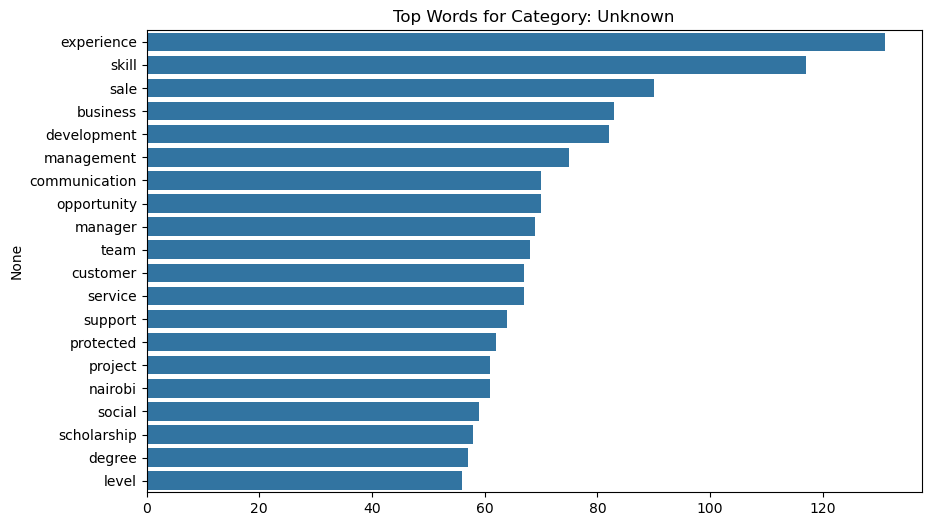

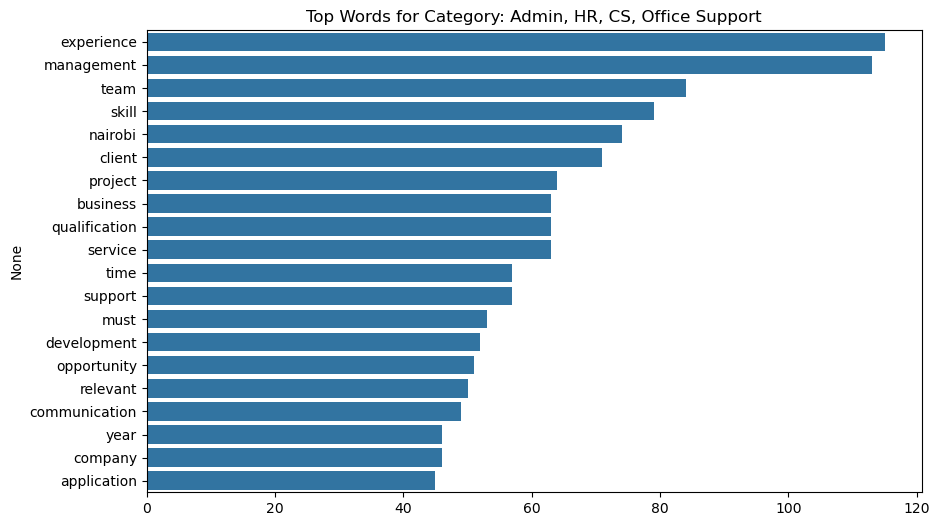

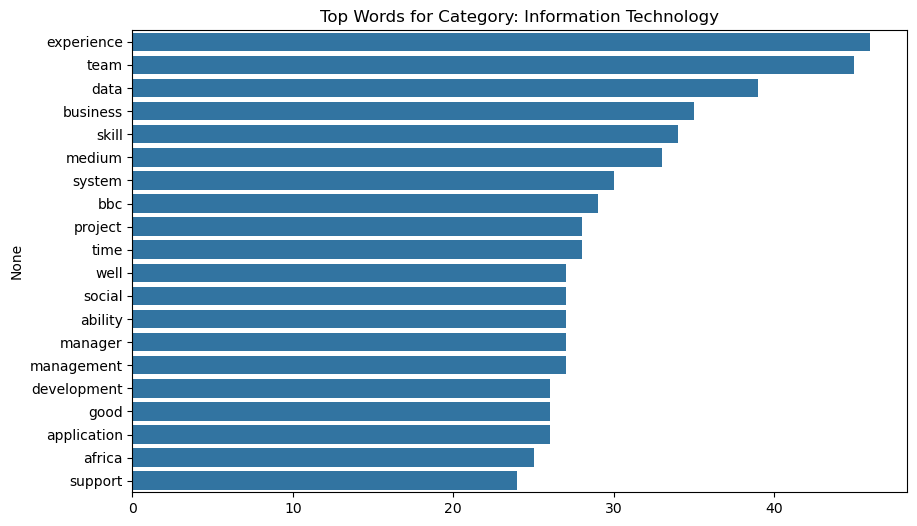

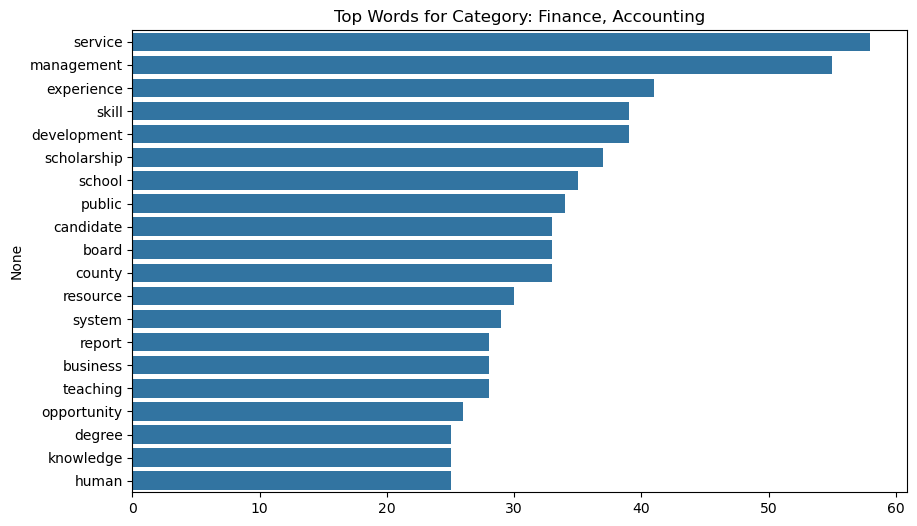

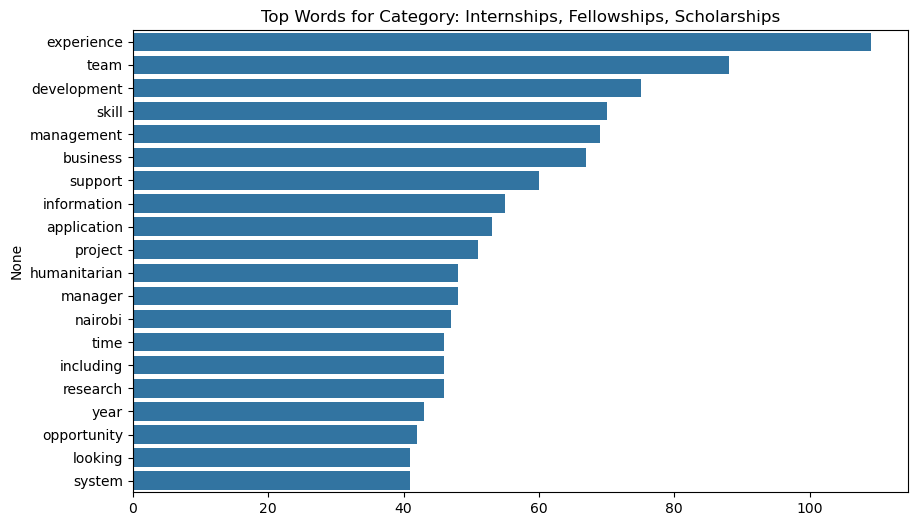

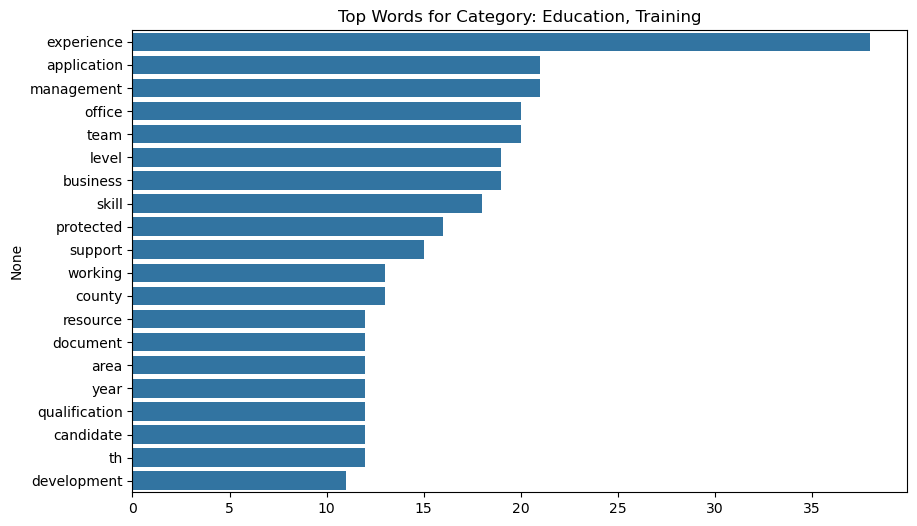

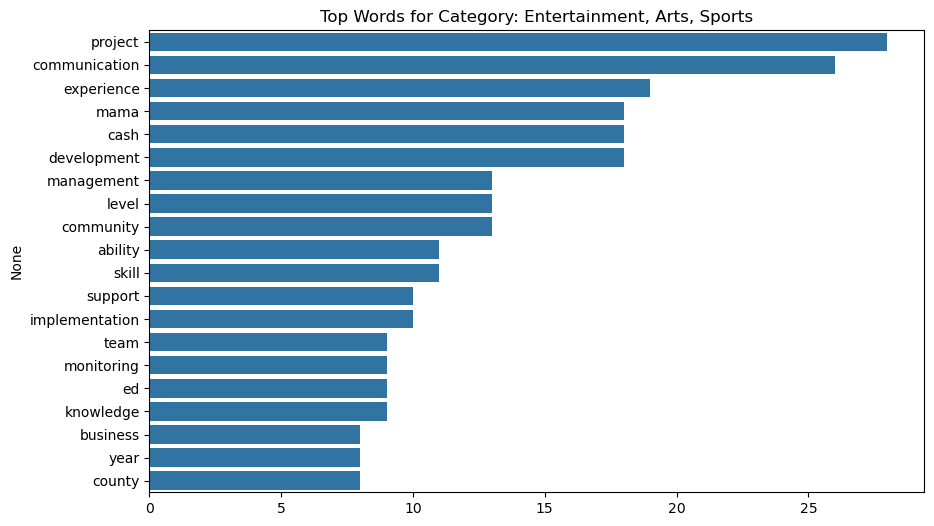

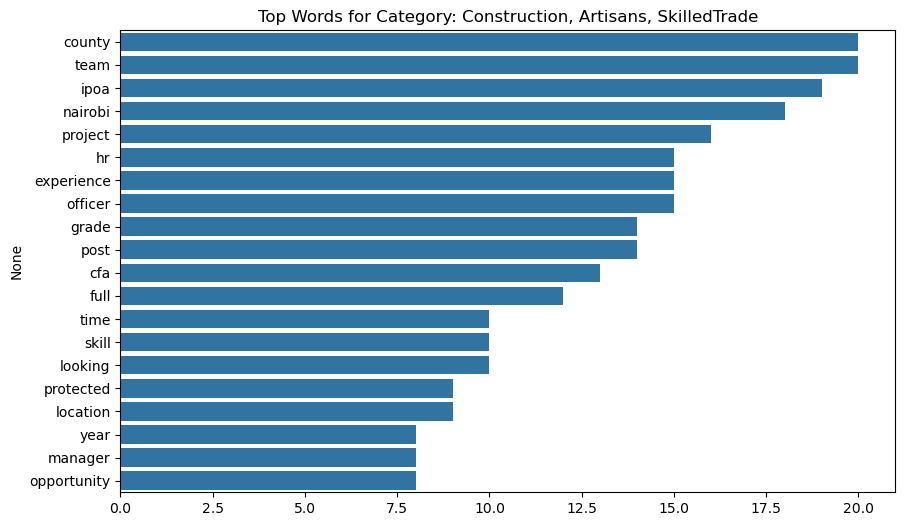

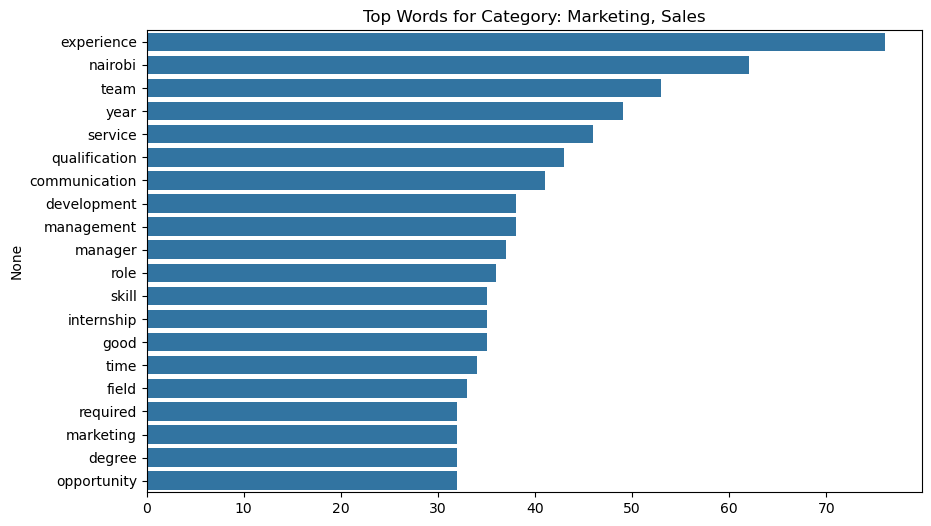

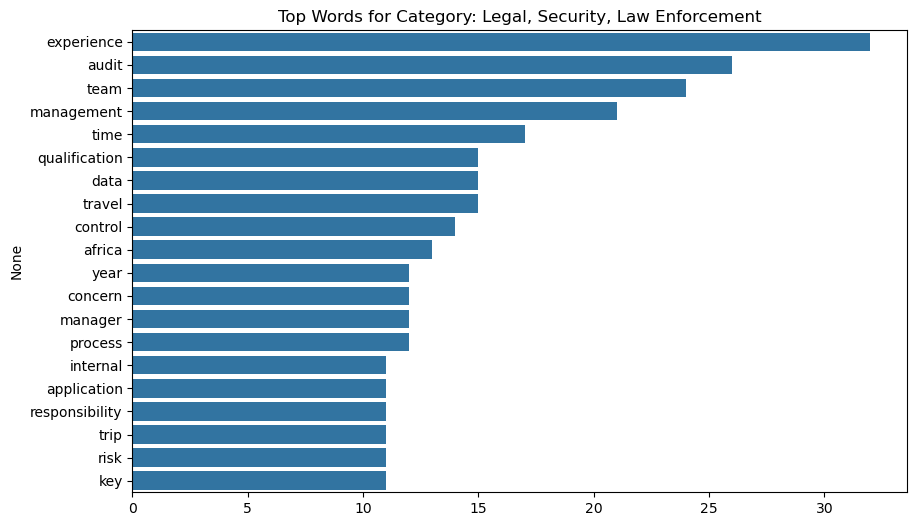

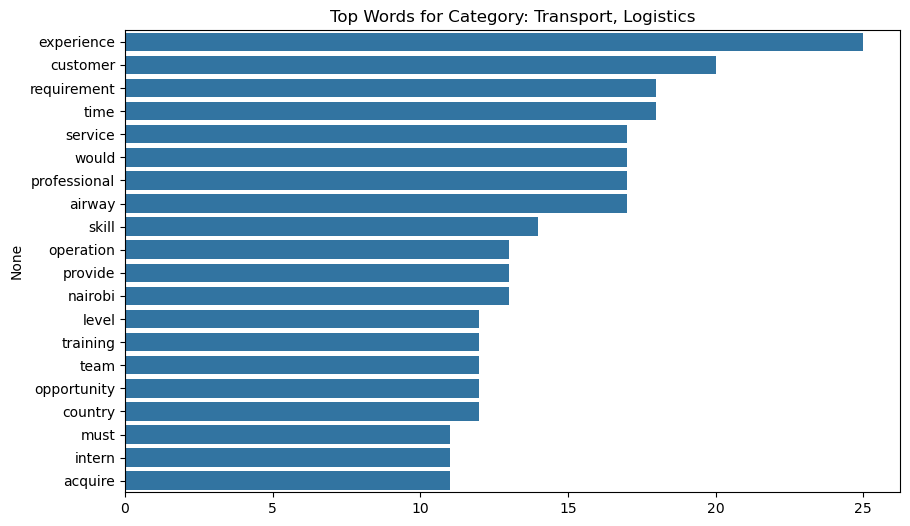

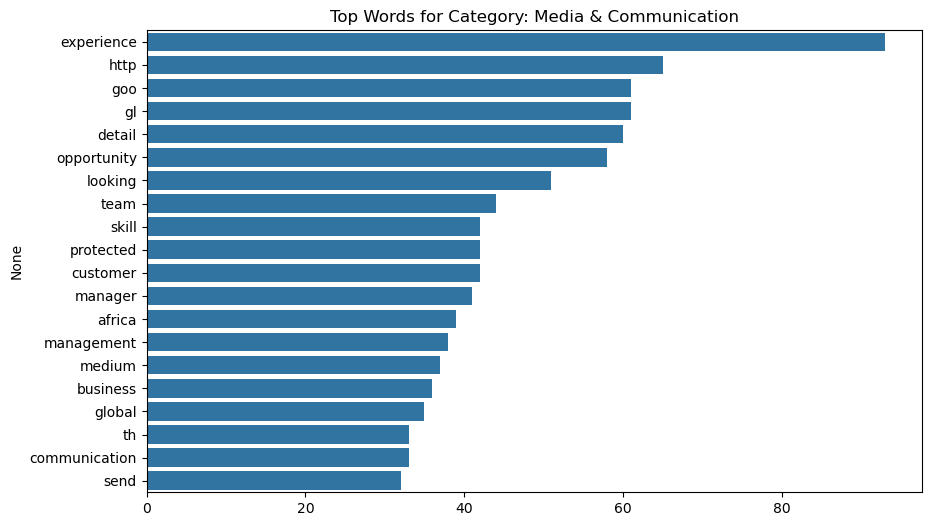

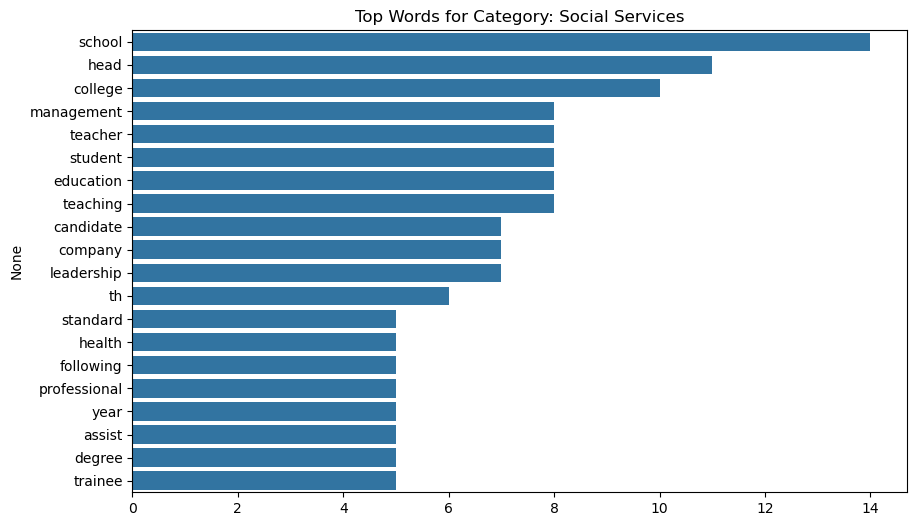

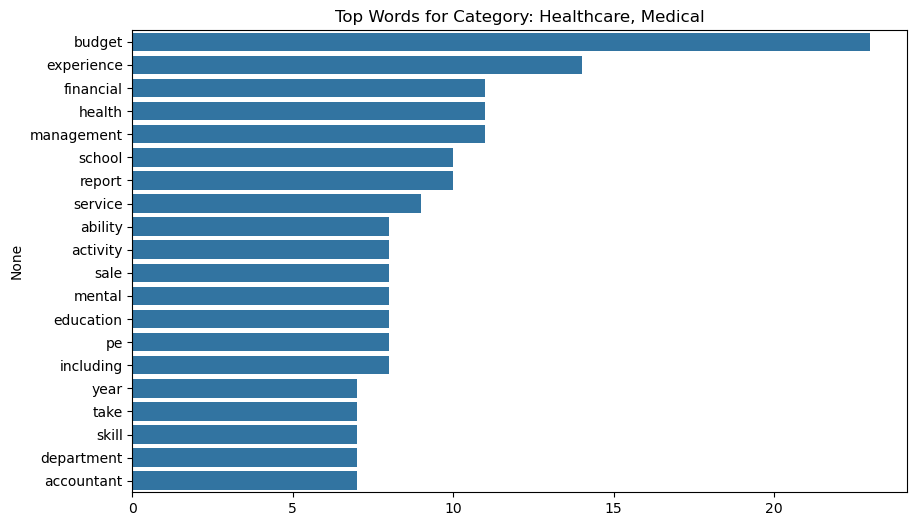

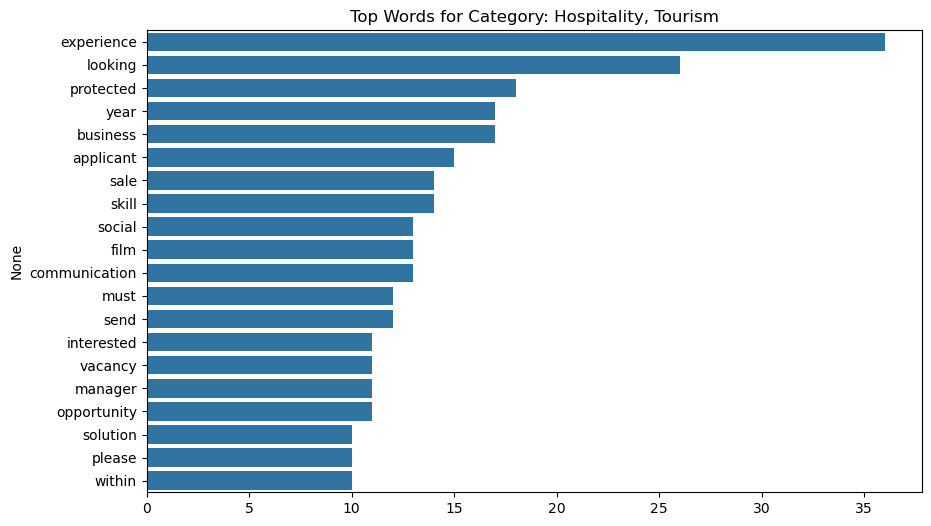

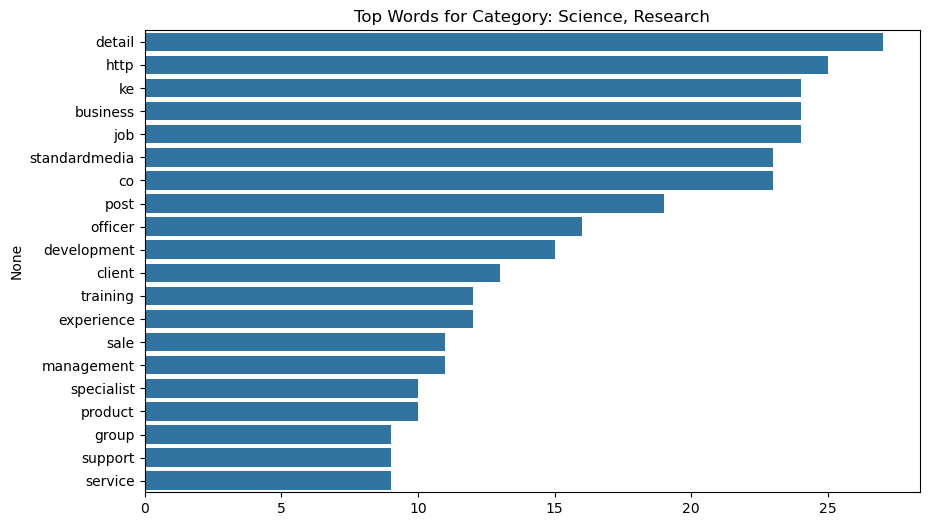

In [37]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Cleaned Job Description'])

# Convert the sparse matrix to a DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate word frequencies per category
word_counts = pd.concat([df['CATEGORY'], X_df], axis=1).groupby('CATEGORY').sum()

# Visualize top words for each category
for category in df['CATEGORY'].unique():
    top_words = word_counts.loc[category].sort_values(ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_words.values, y=top_words.index)
    plt.title(f'Top Words for Category: {category}')
    plt.show()

Split the data using the 80/20 split into training and testing sets 

*NB to self (to remove later). Use random_state to guarantees that the same data points will be assigned to the training and validation sets every time the code is run. This maintains consistency.*

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned Job Description'], df['CATEGORY'], test_size=0.2, random_state=60, stratify=df['CATEGORY'])

### Feature Engineering
Using Term Frequency-Inverse Document Frequency to convert text data into numerical features.

In [52]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Create model and perform hyperparameter tuning
This uses Grid Search

In [53]:
# Define the parameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 10]}

# Create the SVM model
svm_model = SVC()

# Create the grid search object
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

### Evaluate model

In [54]:
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred)) 

Accuracy: 0.5641025641025641
                                        precision    recall  f1-score   support

         Admin, HR, CS, Office Support       0.46      0.57      0.51        23
  Construction, Artisans, SkilledTrade       1.00      0.20      0.33         5
                   Education, Training       1.00      0.50      0.67         6
           Entertainment, Arts, Sports       1.00      0.20      0.33         5
                   Finance, Accounting       0.78      0.58      0.67        12
                   Healthcare, Medical       1.00      0.60      0.75         5
                  Hospitality, Tourism       0.33      0.17      0.22         6
                Information Technology       0.80      0.36      0.50        11
Internships, Fellowships, Scholarships       0.68      0.61      0.64        31
      Legal, Security, Law Enforcement       1.00      0.40      0.57         5
                      Marketing, Sales       0.69      0.65      0.67        17
          

D:\Windows_Applications\Miniconda\envs\karma\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Windows_Applications\Miniconda\envs\karma\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Windows_Applications\Miniconda\envs\karma\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## Self-training

In [60]:
original_unlabeled_df = pd.read_csv('current_unlabeled_data.csv')

In [61]:
original_unlabeled_df.shape

(199, 5)

In [57]:
original_unlabeled_df.isnull().sum()

TITLE                0
LINK                 0
JOB DESCRIPTION     45
DATE                 0
CATEGORY           199
dtype: int64

In [52]:
cleaned_unlabeled_df = original_unlabeled_df.dropna(subset=["JOB DESCRIPTION"])
cleaned_unlabeled_df.count()

TITLE              74
LINK               74
JOB DESCRIPTION    74
DATE               74
CATEGORY            0
dtype: int64

In [53]:
unlabeled_df_copy = cleaned_unlabeled_df.copy()
unlabeled_df_copy['Cleaned Job Description'] = unlabeled_df_copy['JOB DESCRIPTION'].apply(preprocess_text)
unlabeled_df_copy.head()

,TITLE,LINK,JOB DESCRIPTION,DATE,CATEGORY,Cleaned Job Description
0,Apply For KYEOP Training And Entrepreneurship ...,https://opportunitiesforyoungkenyans.co.ke/201...,KYEOP (Kenya Youth Employment Opportunities pr...,1/24/2019,NaN,kyeop kenya youth employment opportunity proje...
4,8 Job Vacancies Open At Burhani Engineers,https://opportunitiesforyoungkenyans.co.ke/201...,We are currently hiring the following persons:...,1/23/2019,NaN,currently hiring following person http www bur...
6,Job Opportunities Open At KNBS,https://opportunitiesforyoungkenyans.co.ke/201...,National Information Platforms for Nutrition (...,1/23/2019,NaN,national information platform nutrition nipn i...
9,Lake Victoria North Water Services Board Inter...,https://opportunitiesforyoungkenyans.co.ke/201...,Vacancy Description Lake Victoria North Water ...,1/23/2019,NaN,vacancy description lake victoria north water ...
10,Standard Media Academy Internship -Journalism,https://opportunitiesforyoungkenyans.co.ke/201...,Standard Media Academy-Journalism The Standard...,1/23/2019,NaN,standard medium academy journalism standard gr...


In [54]:
unlabeled_features = vectorizer.transform(unlabeled_df_copy['Cleaned Job Description'])

predicted_categories = best_model.predict(unlabeled_features)

unlabeled_df_copy['CATEGORY'] = predicted_categories
unlabeled_df_copy = unlabeled_df_copy.drop(columns=['Cleaned Job Description'])

unlabeled_df_copy.to_csv("predicted_categories.csv", index=False)